# Figure 5.B. Reduction in Wolbachia release ratios enabled by prior suppression
Author: Katie Tiley (katherine.tiley@lshtm.ac.uk) <br>
Date: 27 Oct 22 <br>
<br>
Note: in the code RIDL refers to 1gSLT, and IIT refers to Male Wolbachia release

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
from scipy import integrate as sp
import seaborn as sns
from tabulate import tabulate
import pandas as pd
import time
import os

In [2]:
filepath = os.path.abspath(os.getcwd())

### 1. Set up model
Parameters:

In [2]:
# MOSQUITO
alphaO = 0.5  # rate that eggs hatch into larvae
alphaL = 0.18  # rate that larvae pupate
alphaP = 1  # rate that pupae eclose
phi = 500*(1/14)    # number eggs laid per mosquito per day
muO = 0.01    # daily death rate of eggs
muL = 0.1*alphaL    # daily death rate of larvae
muP = 0.1*alphaP     # pupae death rate
muM = 1/14     # adult mosquito death rate
muF = 1/14     # adult female mosquito death rate

# density-dependence via Bellows 1981:
AA = 1   # determines the density at which mortality remains proportionate
BB = 0.5   # determines the 'abruptness' of density-dependence

# WOLBACHIA
fCI = 0.012   # prop of cytoplasmic incompatibility that fails 'sigma'
MT = 0    # prop of wolbachia females that don't successfully maternally transfer 'omega'
c = 0.5      # mating competitiveness of released wolbachia males
cv = 0.128   #coverage of adulticide
e = 1.2      # relative mortality of wolbachia adults compared to wild adults
RR = 1       # release ratio of wolbachia eggs to wild type eggs
RRsupp = 1      # release ratio of wolbachia eggs to wild type eggs for suppression techniques

Initial conditions: (equilibrium values previously defined in Supp)

In [3]:
O0 = 15947.608023052446
OW0 = 0
rOW0 = 0
OS0 = 0
L0 = 40271.71074193975
LW0 = 0
rLW0 = 0
LS0 = 0
P0 = 32.67541200187585
PW0 = 0
rPW0 = 0
PS0 = 0
M0 = 228.72754035145144
MW0 = 0
MS0 = 0
F0 = 228.72754035145144
FW0 = 0

Wolbachia release function:

In [4]:
start_wol = 200

def pulseN(t, start_wol=start_wol, releasenumber=5, frequency=14):    
    for i in range(0,releasenumber,1):
        if round(t) == start_wol + (frequency*i):
            return O0
    else:
        return 0

Suppression functions:

In [5]:
# IIT

def IIT(t, releasenumber=5, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

In [6]:
# SIT / RIDL

switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

In [7]:
# Environmental management

start_em = start_wol-(7*5)
stop_em = 200
em_eff = 1 #0.526

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [8]:
# Larvicides (e.g. guppies)

start_lv = start_wol-(7*5)
stop_lv = 200
lv_eff = 1 #5.95

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [9]:
# Adulticide

h = [] #needed to set adulticide pulses
for i in range(-4, 1, 1):
    h.append((start_wol-7) + (7*i))

def ad(t):    
    ad_eff = 0 #4.9
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01 and round(t) < h[2]:
        return 0
    elif round(t) > h[2]+0.01 and round(t) < h[3]:
        return 0
    elif round(t) > h[3]+0.01 and round(t) < h[4]:
        return 0
    elif round(t) > h[4]+0.01: # and round(t) < h[5]:
        return 0
#    elif round(t) > h[5]+0.01 and round(t) < h[6]:
#        return 0
#    elif round(t) > h[6]+0.01 and round(t) < h[7]:
#        return 0
#    elif round(t) > h[7]+0.01 and round(t) < h[8]:
#        return 0
#    elif round(t) > h[8]+0.01 and round(t) < h[9]:
#        return 0
#    elif round(t) > h[9]+0.01:
#        return 0
    else:
        return ad_eff

Model:

In [10]:
def deriv(y, t, fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch):
    
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = y
    
    #MOSQUITOES
    
    allfemales = 1+F+FW
    allmales = 1+M+MW+(MS*c)
    
    F_nothing = F + FW*MT 
    M_nothing = M + MW*fCI 
    
    F_wol = FW*(1-MT)
    
    #Eggs
    dOdt = em(t) * phi * F_nothing * M_nothing/allmales - alphaO*O - lv(t)*muO*O # eggs laid * females no-wol * (males no_wol / all males) (aka prop no-wol males)
    dOWdt = em(t) * phi * F_wol * (M+MW)/allmales - alphaO*OW - lv(t)*muO*OW 
    drOWdt = pulseN(t)*RR - alphaO*rOW - muO*rOW
    dOSdt = phi * allfemales * (MS*c)/allmales - alphaO*OS - muO*OS
    
    #Larvae
    dLdt =  alphaO*O - alphaL*L - lv(t)*muL*L
    dLWdt = alphaO*OW - alphaL*LW - lv(t)*muL*LW
    drLWdt = alphaO*rOW - alphaL*rLW - muL*rLW
    dLSdt = switch*alphaO*OS - alphaL*LS - muL*LS
    
    #Pupae 
    dPdt =  alphaL*(L/(1+((AA*(L+LW+LS))**BB))) - alphaP*P - lv(t)*muP*P 
    dPWdt = alphaL*(LW/(1+((AA*(L+LW+LS))**BB))) - alphaP*PW - lv(t)*muP*PW
    drPWdt = alphaL*(rLW/(1+((AA*(rLW))**BB))) - alphaP*rPW - muP*rPW 
    dPSdt = alphaL*(LS/(1+((AA*(L+LW+LS))**BB))) - alphaP*PS - muP*PS
        
    #Adult
    dMdt =  .5*alphaP*P - muM*M - ad(t)*M*cv
    dMWdt = IIT(t)*RRsupp + .5*alphaP*(PW+rPW) - muM*1.2*MW - ad(t)*MW*cv
    dMSdt = SIT(t)*RRsupp - muM*1.2*MS #+ .5*alphaP*PS remove for 1gSLT
    
    dFdt =  .5*alphaP*P - muF*F - ad(t)*F*cv
    dFWdt = .5*alphaP*(PW+rPW) - muF*1.2*FW - ad(t)*FW*cv

    return dOdt, dOWdt, drOWdt, dOSdt, dLdt, dLWdt, drLWdt, dLSdt, dPdt, dPWdt, drPWdt, dPSdt, dMdt, dMWdt, dMSdt, dFdt, dFWdt

Model prerequisites:

In [11]:
t = np.linspace(0, 1500, 1501) # grid of time points (in days)
y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # initial condition vector

Run model:

In [12]:
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

Visual check all suppression functions are off and Wolbachia functions is on: (should see Wolbachia come to fixation from day 200)

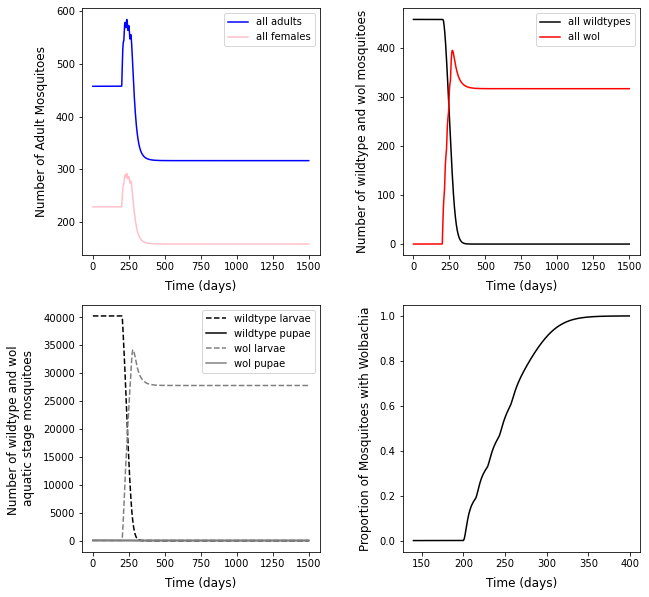

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10,10])

ax1.plot(t, F+FW+M+MW, 'blue', label='all adults')
ax1.plot(t, F+FW, 'pink', label='all females')
ax1.set_xlabel("Time (days)", fontsize=12, labelpad=8)
ax1.set_ylabel("Number of Adult Mosquitoes", fontsize=12, labelpad=8)
ax1.legend()

ax2.plot(t, M+F, 'black', label='all wildtypes')
ax2.plot(t, MW+FW, 'red', label='all wol')
ax2.set_xlabel("Time (days)", fontsize=12, labelpad=8)
ax2.set_ylabel("Number of wildtype and wol mosquitoes", fontsize=12, labelpad=8)
ax2.legend()

ax3.plot(t, L, 'black', linestyle='dashed', label='wildtype larvae')
ax3.plot(t, P, 'black', label='wildtype pupae')
ax3.plot(t, LW, 'grey', linestyle='dashed', label='wol larvae')
ax3.plot(t, PW, 'grey', label='wol pupae')
ax3.set_xlabel("Time (days)", fontsize=12, labelpad=8)
ax3.set_ylabel("Number of wildtype and wol \naquatic stage mosquitoes", fontsize=12, labelpad=8)
ax3.legend()

ax4.plot(t[140:400], (MW[140:400]+FW[140:400])/(MW[140:400]+FW[140:400]+M[140:400]+F[140:400]), 'black')
plt.xticks([150,200,250,300,350,400])
ax4.set_xlabel("Time (days)", fontsize=12, labelpad=8)
ax4.set_ylabel("Proportion of Mosquitoes with Wolbachia", fontsize=12, labelpad=8)


plt.subplots_adjust(wspace=.35)

#plt.savefig('wolAedesDemo-KT', dpi=300, facecolor='w', edgecolor='w',
#        orientation='portrait', format=None, transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

Convert raw eggRR values into adultRR values:

In [15]:
RR_df = pd.read_csv(f'{filepath}/eggRR_adultRR.csv')

def convert_RR(RR):
    return  list(RR_df.loc[RR_df['egg RR'] == RR]['adult RR'])[0]

### 2.a. Data collection: minimum Wolbachia RR with each suppression for fixation after different periods
### No suppression:

In [16]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.5 seconds


In [17]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RR_choosenosupp = RR_vec[sixmonth]
RR_choosenosupp = convert_RR(RR_choosenosupp)
RR_choosenosupp

## returns error if there is no fixation

0.0775

### RIDL:

In [18]:
RIDL_df = pd.read_csv(f'{filepath}/RIDL_df.csv')

In [19]:
switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=1, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 45, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [20]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.69 seconds


In [21]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RIDL_choose1wk = RR_vec[sixmonth]
RIDL_choose1wk = convert_RR(RIDL_choose1wk)

In [22]:
switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=2, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 45, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [23]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.07 seconds


In [24]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RIDL_choose2wk = RR_vec[sixmonth]
RIDL_choose2wk = convert_RR(RIDL_choose2wk)

In [25]:
switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=3, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 45, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [26]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.35 seconds


In [27]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RIDL_choose3wk = RR_vec[sixmonth]
RIDL_choose3wk = convert_RR(RIDL_choose3wk)

In [28]:
switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=4, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 45, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [29]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.49 seconds


In [30]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RIDL_choose4wk = RR_vec[sixmonth]
RIDL_choose4wk = convert_RR(RIDL_choose4wk)

In [31]:
switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 45, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [32]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.72 seconds


In [33]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RIDL_choose5wk = RR_vec[sixmonth]
RIDL_choose5wk = convert_RR(RIDL_choose5wk)

In [34]:
switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=6, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 70, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [35]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.98 seconds


In [36]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RIDL_choose6wk = RR_vec[sixmonth]
RIDL_choose6wk = convert_RR(RIDL_choose6wk)

In [37]:
switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=7, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 70, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [38]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.24 seconds


In [39]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RIDL_choose7wk = RR_vec[sixmonth]
RIDL_choose7wk = convert_RR(RIDL_choose7wk)

In [40]:
switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=8, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 70, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [41]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.45 seconds


In [42]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RIDL_choose8wk = RR_vec[sixmonth]
RIDL_choose8wk = convert_RR(RIDL_choose8wk)

In [43]:
switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=9, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 70, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [44]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.79 seconds


In [45]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RIDL_choose9wk = RR_vec[sixmonth]
RIDL_choose9wk = convert_RR(RIDL_choose9wk)

In [46]:
switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=10, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 70, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [47]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 8.02 seconds


In [48]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RIDL_choose10wk = RR_vec[sixmonth]
RIDL_choose10wk = convert_RR(RIDL_choose10wk)

Store results:

In [49]:
weekfig_df = pd.DataFrame({'Suppression type': 'RIDL', '1wk': RIDL_choose1wk, '2wk': RIDL_choose2wk, '3wk': RIDL_choose3wk,
           '4wk': RIDL_choose4wk, '5wk': RIDL_choose5wk, '6wk': RIDL_choose6wk, '7wk': RIDL_choose7wk,
           '8wk': RIDL_choose8wk, '9wk': RIDL_choose9wk, '10wk': RIDL_choose10wk}, index=[0])

weekfig_df

,Suppression type,1wk,2wk,3wk,4wk,5wk,6wk,7wk,8wk,9wk,10wk
0,RIDL,0.0675,0.06,0.0525,0.0475,0.0425,0.0075,0.005,0.0025,0.0025,0.0025


In [50]:
# switch off

switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

### SIT:

In [51]:
SIT_df = pd.read_csv(f'{filepath}/SIT_df.csv')

In [52]:
switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=1, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0]

In [53]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.8 seconds


In [54]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
SIT_choose1wk = RR_vec[sixmonth]
SIT_choose1wk = convert_RR(SIT_choose1wk)

In [55]:
switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=2, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0]

In [56]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.11 seconds


In [57]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
SIT_choose2wk = RR_vec[sixmonth]
SIT_choose2wk = convert_RR(SIT_choose2wk)

In [58]:
switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=3, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0]

In [59]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.38 seconds


In [60]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
SIT_choose3wk = RR_vec[sixmonth]
SIT_choose3wk = convert_RR(SIT_choose3wk)

In [61]:
switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=4, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0]

In [62]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.61 seconds


In [63]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
SIT_choose4wk = RR_vec[sixmonth]
SIT_choose4wk = convert_RR(SIT_choose4wk)

In [64]:
switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [65]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.94 seconds


In [66]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
SIT_choose5wk = RR_vec[sixmonth]
SIT_choose5wk = convert_RR(SIT_choose5wk)

In [67]:
switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=6, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [68]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.96 seconds


In [69]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
SIT_choose6wk = RR_vec[sixmonth]
SIT_choose6wk = convert_RR(SIT_choose6wk)

In [70]:
switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=7, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [71]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.24 seconds


In [72]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
SIT_choose7wk = RR_vec[sixmonth]
SIT_choose7wk = convert_RR(SIT_choose7wk)

In [73]:
switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=8, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [74]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.48 seconds


In [75]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
SIT_choose8wk = RR_vec[sixmonth]
SIT_choose8wk = convert_RR(SIT_choose8wk)

In [76]:
switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=9, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [77]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.82 seconds


In [78]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
SIT_choose9wk = RR_vec[sixmonth]
SIT_choose9wk = convert_RR(SIT_choose9wk)

In [79]:
switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=10, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [80]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.91 seconds


In [81]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
SIT_choose10wk = RR_vec[sixmonth]
SIT_choose10wk = convert_RR(SIT_choose10wk)

Store results:

In [82]:
SIT_week = {'Suppression type': 'SIT', '1wk': SIT_choose1wk, '2wk': SIT_choose2wk, '3wk': SIT_choose3wk,
           '4wk': SIT_choose4wk, '5wk': SIT_choose5wk, '6wk': SIT_choose6wk, '7wk': SIT_choose7wk,
           '8wk': SIT_choose8wk, '9wk': SIT_choose9wk, '10wk': SIT_choose10wk}
weekfig_df = weekfig_df.append(SIT_week, ignore_index=True)

weekfig_df

,Suppression type,1wk,2wk,3wk,4wk,5wk,6wk,7wk,8wk,9wk,10wk
0,RIDL,0.0675,0.06,0.0525,0.0475,0.0425,0.0075,0.005,0.0025,0.0025,0.0025
1,SIT,0.0675,0.06,0.0525,0.0475,0.0425,0.0375,0.035,0.0300,0.0275,0.0250


In [83]:
# switch off

switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

### IIT:

In [84]:
IIT_df = pd.read_csv(f'{filepath}/IIT_df.csv')

In [85]:
def IIT(t, releasenumber=1, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0
        
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 60, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [86]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.56 seconds


In [87]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
IIT_choose1wk = RR_vec[sixmonth]
IIT_choose1wk = convert_RR(IIT_choose1wk)

In [88]:
def IIT(t, releasenumber=2, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0
        
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 60, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [89]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.84 seconds


In [90]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
IIT_choose2wk = RR_vec[sixmonth]
IIT_choose2wk = convert_RR(IIT_choose2wk)

In [91]:
def IIT(t, releasenumber=3, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0
        
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 60, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [92]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.2 seconds


In [93]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
IIT_choose3wk = RR_vec[sixmonth]
IIT_choose3wk = convert_RR(IIT_choose3wk)

In [94]:
def IIT(t, releasenumber=4, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0
        
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 60, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [95]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.45 seconds


In [96]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
IIT_choose4wk = RR_vec[sixmonth]
IIT_choose4wk = convert_RR(IIT_choose4wk)

In [97]:
def IIT(t, releasenumber=5, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0
        
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 60, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [98]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.7 seconds


In [99]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
IIT_choose5wk = RR_vec[sixmonth]
IIT_choose5wk = convert_RR(IIT_choose5wk)

In [100]:
def IIT(t, releasenumber=6, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0
        
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 95, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [101]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.97 seconds


In [102]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
IIT_choose6wk = RR_vec[sixmonth]
IIT_choose6wk = convert_RR(IIT_choose6wk)

In [103]:
def IIT(t, releasenumber=7, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0
        
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 95, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [104]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.49 seconds


In [105]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
IIT_choose7wk = RR_vec[sixmonth]
IIT_choose7wk = convert_RR(IIT_choose7wk)

In [106]:
def IIT(t, releasenumber=8, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0
        
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 95, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [107]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.51 seconds


In [108]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
IIT_choose8wk = RR_vec[sixmonth]
IIT_choose8wk = convert_RR(IIT_choose8wk)

In [109]:
def IIT(t, releasenumber=9, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0
        
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 95, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [110]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.65 seconds


In [111]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
IIT_choose9wk = RR_vec[sixmonth]
IIT_choose9wk = convert_RR(IIT_choose9wk)

In [112]:
def IIT(t, releasenumber=10, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0
        
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 95, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [113]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.87 seconds


In [114]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
IIT_choose10wk = RR_vec[sixmonth]
IIT_choose10wk = convert_RR(IIT_choose10wk)

Store results:

In [115]:
IIT_week = {'Suppression type': 'IIT', '1wk': IIT_choose1wk, '2wk': IIT_choose2wk, '3wk': IIT_choose3wk,
           '4wk': IIT_choose4wk, '5wk': IIT_choose5wk, '6wk': IIT_choose6wk, '7wk': IIT_choose7wk,
           '8wk': IIT_choose8wk, '9wk': IIT_choose9wk, '10wk': IIT_choose10wk}
weekfig_df = weekfig_df.append(IIT_week, ignore_index=True)

weekfig_df

,Suppression type,1wk,2wk,3wk,4wk,5wk,6wk,7wk,8wk,9wk,10wk
0,RIDL,0.0675,0.06,0.0525,0.0475,0.0425,0.0075,0.0050,0.0025,0.0025,0.0025
1,SIT,0.0675,0.06,0.0525,0.0475,0.0425,0.0375,0.0350,0.0300,0.0275,0.0250
2,IIT,0.0550,0.04,0.0300,0.0225,0.0150,0.0025,0.0025,0.0025,0.0025,0.0025


In [116]:
# switch off

def IIT(t, releasenumber=5, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

### Environmental Management:

In [117]:
EM_df = pd.read_csv(f'{filepath}/EM_df.csv')

In [118]:
start_em = start_wol-(7*1)
stop_em = 200
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 47.4, 'Efficacy parameter'])
em_eff = em_eff[0]

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [119]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.65 seconds


In [120]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
EM_choose1wk = RR_vec[sixmonth]
EM_choose1wk = convert_RR(EM_choose1wk)

In [121]:
start_em = start_wol-(7*2)
stop_em = 200
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 47.4, 'Efficacy parameter'])
em_eff = em_eff[0]

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [122]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.66 seconds


In [123]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
EM_choose2wk = RR_vec[sixmonth]
EM_choose2wk = convert_RR(EM_choose2wk)

In [124]:
start_em = start_wol-(7*3)
stop_em = 200
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 47.4, 'Efficacy parameter'])
em_eff = em_eff[0]

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [125]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.58 seconds


In [126]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
EM_choose3wk = RR_vec[sixmonth]
EM_choose3wk = convert_RR(EM_choose3wk)

In [127]:
start_em = start_wol-(7*4)
stop_em = 200
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 47.4, 'Efficacy parameter'])
em_eff = em_eff[0]

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [128]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.43 seconds


In [129]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
EM_choose4wk = RR_vec[sixmonth]
EM_choose4wk = convert_RR(EM_choose4wk)

In [130]:
start_em = start_wol-(7*5)
stop_em = 200
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 47.4, 'Efficacy parameter'])
em_eff = em_eff[0]

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [131]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.48 seconds


In [132]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
EM_choose5wk = RR_vec[sixmonth]
EM_choose5wk = convert_RR(EM_choose5wk)

In [133]:
start_em = start_wol-(7*6)
stop_em = 200
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 47.4, 'Efficacy parameter'])
em_eff = em_eff[0]

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [134]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.47 seconds


In [135]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
EM_choose6wk = RR_vec[sixmonth]
EM_choose6wk = convert_RR(EM_choose6wk)

In [136]:
start_em = start_wol-(7*7)
stop_em = 200
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 47.4, 'Efficacy parameter'])
em_eff = em_eff[0]

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [137]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.5 seconds


In [138]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
EM_choose7wk = RR_vec[sixmonth]
EM_choose7wk = convert_RR(EM_choose7wk)

In [139]:
start_em = start_wol-(7*8)
stop_em = 200
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 47.4, 'Efficacy parameter'])
em_eff = em_eff[0]

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [140]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.51 seconds


In [141]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
EM_choose8wk = RR_vec[sixmonth]
EM_choose8wk = convert_RR(EM_choose8wk)

In [142]:
start_em = start_wol-(7*9)
stop_em = 200
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 47.4, 'Efficacy parameter'])
em_eff = em_eff[0]

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [143]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.5 seconds


In [144]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
EM_choose9wk = RR_vec[sixmonth]
EM_choose9wk = convert_RR(EM_choose9wk)

In [145]:
start_em = start_wol-(7*10)
stop_em = 200
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 47.4, 'Efficacy parameter'])
em_eff = em_eff[0]

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [146]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.45 seconds


In [147]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
EM_choose10wk = RR_vec[sixmonth]
EM_choose10wk = convert_RR(EM_choose10wk)

Store results:

In [148]:
EM_week = {'Suppression type': 'EM', '1wk': EM_choose1wk, '2wk': EM_choose2wk, '3wk': EM_choose3wk,
           '4wk': EM_choose4wk, '5wk': EM_choose5wk, '6wk': EM_choose6wk, '7wk': EM_choose7wk,
           '8wk': EM_choose8wk, '9wk': EM_choose9wk, '10wk': EM_choose10wk}
weekfig_df = weekfig_df.append(EM_week, ignore_index=True)

weekfig_df

,Suppression type,1wk,2wk,3wk,4wk,5wk,6wk,7wk,8wk,9wk,10wk
0,RIDL,0.0675,0.06,0.0525,0.0475,0.0425,0.0075,0.0050,0.0025,0.0025,0.0025
1,SIT,0.0675,0.06,0.0525,0.0475,0.0425,0.0375,0.0350,0.0300,0.0275,0.0250
2,IIT,0.0550,0.04,0.0300,0.0225,0.0150,0.0025,0.0025,0.0025,0.0025,0.0025
3,EM,0.0725,0.07,0.0675,0.0650,0.0625,0.0600,0.0600,0.0575,0.0575,0.0575


In [149]:
# switch off

start_em = start_wol-(7*5)
stop_em = 200
em_eff = 1

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

### Larvicide:

In [150]:
LV_df = pd.read_csv(f'{filepath}/LV_df.csv')

In [151]:
start_lv = start_wol-(7*1)
stop_lv = 200
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 45, 'Efficacy parameter'])
lv_eff = lv_eff[0]

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [152]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.61 seconds


In [153]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
LV_choose1wk = RR_vec[sixmonth]
LV_choose1wk = convert_RR(LV_choose1wk)

In [154]:
start_lv = start_wol-(7*2)
stop_lv = 200
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 45, 'Efficacy parameter'])
lv_eff = lv_eff[0]

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [155]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.59 seconds


In [156]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
LV_choose2wk = RR_vec[sixmonth]
LV_choose2wk = convert_RR(LV_choose2wk)

In [157]:
start_lv = start_wol-(7*3)
stop_lv = 200
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 45, 'Efficacy parameter'])
lv_eff = lv_eff[0]

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [158]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.44 seconds


In [159]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
LV_choose3wk = RR_vec[sixmonth]
LV_choose3wk = convert_RR(LV_choose3wk)

In [160]:
start_lv = start_wol-(7*4)
stop_lv = 200
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 45, 'Efficacy parameter'])
lv_eff = lv_eff[0]

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [161]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.39 seconds


In [162]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
LV_choose4wk = RR_vec[sixmonth]
LV_choose4wk = convert_RR(LV_choose4wk)

In [163]:
start_lv = start_wol-(7*5)
stop_lv = 200
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 45, 'Efficacy parameter'])
lv_eff = lv_eff[0]

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [164]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.4 seconds


In [165]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
LV_choose5wk = RR_vec[sixmonth]
LV_choose5wk = convert_RR(LV_choose5wk)

In [166]:
start_lv = start_wol-(7*6)
stop_lv = 200
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 45, 'Efficacy parameter'])
lv_eff = lv_eff[0]

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [167]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.49 seconds


In [168]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
LV_choose6wk = RR_vec[sixmonth]
LV_choose6wk = convert_RR(LV_choose6wk)

In [169]:
start_lv = start_wol-(7*7)
stop_lv = 200
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 45, 'Efficacy parameter'])
lv_eff = lv_eff[0]

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [170]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.46 seconds


In [171]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
LV_choose7wk = RR_vec[sixmonth]
LV_choose7wk = convert_RR(LV_choose7wk)

In [172]:
start_lv = start_wol-(7*8)
stop_lv = 200
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 45, 'Efficacy parameter'])
lv_eff = lv_eff[0]

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [173]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.43 seconds


In [174]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
LV_choose8wk = RR_vec[sixmonth]
LV_choose8wk = convert_RR(LV_choose8wk)

In [175]:
start_lv = start_wol-(7*9)
stop_lv = 200
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 45, 'Efficacy parameter'])
lv_eff = lv_eff[0]

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [176]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.54 seconds


In [177]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
LV_choose9wk = RR_vec[sixmonth]
LV_choose9wk = convert_RR(LV_choose9wk)

In [178]:
start_lv = start_wol-(7*10)
stop_lv = 200
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 45, 'Efficacy parameter'])
lv_eff = lv_eff[0]

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [179]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.93 seconds


In [180]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
LV_choose10wk = RR_vec[sixmonth]
LV_choose10wk = convert_RR(LV_choose10wk)

Store results:

In [181]:
LV_week = {'Suppression type': 'LV', '1wk': LV_choose1wk, '2wk': LV_choose2wk, '3wk': LV_choose3wk,
           '4wk': LV_choose4wk, '5wk': LV_choose5wk, '6wk': LV_choose6wk, '7wk': LV_choose7wk,
           '8wk': LV_choose8wk, '9wk': LV_choose9wk, '10wk': LV_choose10wk}
weekfig_df = weekfig_df.append(LV_week, ignore_index=True)

weekfig_df

,Suppression type,1wk,2wk,3wk,4wk,5wk,6wk,7wk,8wk,9wk,10wk
0,RIDL,0.0675,0.06,0.0525,0.0475,0.0425,0.0075,0.0050,0.0025,0.0025,0.0025
1,SIT,0.0675,0.06,0.0525,0.0475,0.0425,0.0375,0.0350,0.0300,0.0275,0.0250
2,IIT,0.0550,0.04,0.0300,0.0225,0.0150,0.0025,0.0025,0.0025,0.0025,0.0025
3,EM,0.0725,0.07,0.0675,0.0650,0.0625,0.0600,0.0600,0.0575,0.0575,0.0575
4,LV,0.0725,0.07,0.0675,0.0650,0.0650,0.0625,0.0625,0.0625,0.0600,0.0600


In [182]:
# switch off

start_lv = start_wol-(7*5)
stop_lv = 200
lv_eff = 1

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

### Adulticide

In [183]:
AD_df = pd.read_csv(f'{filepath}/AD_df.csv')

In [184]:
h = [] #needed to set adulticide pulses
for i in range(0, 1, 1):
    h.append((start_wol-7) + (7*i))

ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Efficacy parameter'])
ad_eff = ad_eff[0]
cv = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Coverage value'])
cv = cv[0]
    
def ad(t):    
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01:
        return 0
    else:
        return ad_eff

In [185]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 4.68 seconds


In [186]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
AD_choose1wk = RR_vec[sixmonth]
AD_choose1wk = convert_RR(AD_choose1wk)

In [187]:
h = [] #needed to set adulticide pulses
for i in range(-1, 1, 1):
    h.append((start_wol-7) + (7*i))

ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Efficacy parameter'])
ad_eff = ad_eff[0]
cv = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Coverage value'])
cv = cv[0]
    
def ad(t):    
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01:
        return 0
    else:
        return ad_eff

In [188]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.18 seconds


In [189]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
AD_choose2wk = RR_vec[sixmonth]
AD_choose2wk = convert_RR(AD_choose2wk)

In [190]:
h = [] #needed to set adulticide pulses
for i in range(-2, 1, 1):
    h.append((start_wol-7) + (7*i))

ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Efficacy parameter'])
ad_eff = ad_eff[0]
cv = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Coverage value'])
cv = cv[0]
    
def ad(t):    
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01 and round(t) < h[2]:
        return 0
    elif round(t) > h[2]+0.01:
        return 0
    else:
        return ad_eff

In [191]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.55 seconds


In [192]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
AD_choose3wk = RR_vec[sixmonth]
AD_choose3wk = convert_RR(AD_choose3wk)

In [193]:
h = [] #needed to set adulticide pulses
for i in range(-3, 1, 1):
    h.append((start_wol-7) + (7*i))

ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Efficacy parameter'])
ad_eff = ad_eff[0]
cv = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Coverage value'])
cv = cv[0]
    
def ad(t):    
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01 and round(t) < h[2]:
        return 0
    elif round(t) > h[2]+0.01 and round(t) < h[3]:
        return 0
    elif round(t) > h[3]+0.01:
        return 0
    else:
        return ad_eff

In [194]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.92 seconds


In [195]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
AD_choose4wk = RR_vec[sixmonth]
AD_choose4wk = convert_RR(AD_choose4wk)

In [196]:
cv = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Coverage value'])
cv = cv[0]
cv

0.141

In [197]:
h = [] #needed to set adulticide pulses
for i in range(-4, 1, 1):
    h.append((start_wol-7) + (7*i))

ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Efficacy parameter'])
ad_eff = ad_eff[0]
cv = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Coverage value'])
cv = cv[0]
    
def ad(t):    
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01 and round(t) < h[2]:
        return 0
    elif round(t) > h[2]+0.01 and round(t) < h[3]:
        return 0
    elif round(t) > h[3]+0.01 and round(t) < h[4]:
        return 0
    elif round(t) > h[4]+0.01:
        return 0
    else:
        return ad_eff

In [198]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.59 seconds


In [199]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
AD_choose5wk = RR_vec[sixmonth]
AD_choose5wk = convert_RR(AD_choose5wk)

In [200]:
h = [] #needed to set adulticide pulses
for i in range(-5, 1, 1):
    h.append((start_wol-7) + (7*i))

ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Efficacy parameter'])
ad_eff = ad_eff[0]
cv = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Coverage value'])
cv = cv[0]
    
def ad(t):    
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01 and round(t) < h[2]:
        return 0
    elif round(t) > h[2]+0.01 and round(t) < h[3]:
        return 0
    elif round(t) > h[3]+0.01 and round(t) < h[4]:
        return 0
    elif round(t) > h[4]+0.01 and round(t) < h[5]:
        return 0
    elif round(t) > h[5]+0.01:
        return 0
    else:
        return ad_eff

In [201]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.08 seconds


In [202]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
AD_choose6wk = RR_vec[sixmonth]
AD_choose6wk = convert_RR(AD_choose6wk)

In [203]:
h = [] #needed to set adulticide pulses
for i in range(-6, 1, 1):
    h.append((start_wol-7) + (7*i))

ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Efficacy parameter'])
ad_eff = ad_eff[0]
cv = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Coverage value'])
cv = cv[0]
    
def ad(t):    
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01 and round(t) < h[2]:
        return 0
    elif round(t) > h[2]+0.01 and round(t) < h[3]:
        return 0
    elif round(t) > h[3]+0.01 and round(t) < h[4]:
        return 0
    elif round(t) > h[4]+0.01 and round(t) < h[5]:
        return 0
    elif round(t) > h[5]+0.01 and round(t) < h[6]:
        return 0
    elif round(t) > h[6]+0.01:
        return 0
    else:
        return ad_eff

In [204]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.62 seconds


In [205]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
AD_choose7wk = RR_vec[sixmonth]
AD_choose7wk = convert_RR(AD_choose7wk)

In [206]:
h = [] #needed to set adulticide pulses
for i in range(-7, 1, 1):
    h.append((start_wol-7) + (7*i))

ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Efficacy parameter'])
ad_eff = ad_eff[0]
cv = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Coverage value'])
cv = cv[0]
    
def ad(t):    
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01 and round(t) < h[2]:
        return 0
    elif round(t) > h[2]+0.01 and round(t) < h[3]:
        return 0
    elif round(t) > h[3]+0.01 and round(t) < h[4]:
        return 0
    elif round(t) > h[4]+0.01 and round(t) < h[5]:
        return 0
    elif round(t) > h[5]+0.01 and round(t) < h[6]:
        return 0
    elif round(t) > h[6]+0.01 and round(t) < h[7]:
        return 0
    elif round(t) > h[7]+0.01:
        return 0
    else:
        return ad_eff

In [207]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 8.4 seconds


In [208]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
AD_choose8wk = RR_vec[sixmonth]
AD_choose8wk = convert_RR(AD_choose8wk)

In [209]:
h = [] #needed to set adulticide pulses
for i in range(-8, 1, 1):
    h.append((start_wol-7) + (7*i))

ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Efficacy parameter'])
ad_eff = ad_eff[0]
cv = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Coverage value'])
cv = cv[0]
    
def ad(t):    
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01 and round(t) < h[2]:
        return 0
    elif round(t) > h[2]+0.01 and round(t) < h[3]:
        return 0
    elif round(t) > h[3]+0.01 and round(t) < h[4]:
        return 0
    elif round(t) > h[4]+0.01 and round(t) < h[5]:
        return 0
    elif round(t) > h[5]+0.01 and round(t) < h[6]:
        return 0
    elif round(t) > h[6]+0.01 and round(t) < h[7]:
        return 0
    elif round(t) > h[7]+0.01 and round(t) < h[8]:
        return 0
    elif round(t) > h[8]+0.01:
        return 0
    else:
        return ad_eff

In [210]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 9.05 seconds


In [211]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
AD_choose9wk = RR_vec[sixmonth]
AD_choose9wk = convert_RR(AD_choose9wk)

In [212]:
h = [] #needed to set adulticide pulses
for i in range(-9, 1, 1):
    h.append((start_wol-7) + (7*i))

ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Efficacy parameter'])
ad_eff = ad_eff[0]
cv = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Coverage value'])
cv = cv[0]
    
def ad(t):    
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01 and round(t) < h[2]:
        return 0
    elif round(t) > h[2]+0.01 and round(t) < h[3]:
        return 0
    elif round(t) > h[3]+0.01 and round(t) < h[4]:
        return 0
    elif round(t) > h[4]+0.01 and round(t) < h[5]:
        return 0
    elif round(t) > h[5]+0.01 and round(t) < h[6]:
        return 0
    elif round(t) > h[6]+0.01 and round(t) < h[7]:
        return 0
    elif round(t) > h[7]+0.01 and round(t) < h[8]:
        return 0
    elif round(t) > h[8]+0.01 and round(t) < h[9]:
        return 0
    elif round(t) > h[9]+0.01:
        return 0
    else:
        return ad_eff

In [213]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 9.37 seconds


In [214]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
AD_choose10wk = RR_vec[sixmonth]
AD_choose10wk = convert_RR(AD_choose10wk)

Store results:

In [215]:
AD_week = {'Suppression type': 'AD', '1wk': AD_choose1wk, '2wk': AD_choose2wk, '3wk': AD_choose3wk,
           '4wk': AD_choose4wk, '5wk': AD_choose5wk, '6wk': AD_choose6wk, '7wk': AD_choose7wk,
           '8wk': AD_choose8wk, '9wk': AD_choose9wk, '10wk': AD_choose10wk}
weekfig_df = weekfig_df.append(AD_week, ignore_index=True)

weekfig_df

,Suppression type,1wk,2wk,3wk,4wk,5wk,6wk,7wk,8wk,9wk,10wk
0,RIDL,0.0675,0.0600,0.0525,0.0475,0.0425,0.0075,0.0050,0.0025,0.0025,0.0025
1,SIT,0.0675,0.0600,0.0525,0.0475,0.0425,0.0375,0.0350,0.0300,0.0275,0.0250
2,IIT,0.0550,0.0400,0.0300,0.0225,0.0150,0.0025,0.0025,0.0025,0.0025,0.0025
3,EM,0.0725,0.0700,0.0675,0.0650,0.0625,0.0600,0.0600,0.0575,0.0575,0.0575
4,LV,0.0725,0.0700,0.0675,0.0650,0.0650,0.0625,0.0625,0.0625,0.0600,0.0600
5,AD,0.0650,0.0575,0.0525,0.0500,0.0475,0.0450,0.0450,0.0425,0.0425,0.0425


In [216]:
weekfig_df.to_csv('weekfig_df.csv')

In [217]:
# switch off

h = [] #needed to set adulticide pulses
for i in range(-4, 1, 1):
    h.append((start_wol-7) + (7*i))

ad_eff = 0
    
def ad(t):    
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01:
        return 0
    else:
        return ad_eff

### 2.b. Data formatting: minimum Wolbachia RR relative to no suppression for fixation within 6 months

#### To run if not running script all-through:

In [7]:
weekfig_df = pd.read_csv(f'{filepath}/weekfig_df.csv')

RR_choosenosupp = 0.0775

In [8]:
weekfig_df.drop('Suppression type', inplace=True, axis=1)
weekfig_df

,1wk,2wk,3wk,4wk,5wk,6wk,7wk,8wk,9wk,10wk
0,0.0675,0.0600,0.0525,0.0475,0.0425,0.0075,0.0050,0.0025,0.0025,0.0025
1,0.0675,0.0600,0.0525,0.0475,0.0425,0.0375,0.0350,0.0300,0.0275,0.0250
2,0.0550,0.0400,0.0300,0.0225,0.0150,0.0025,0.0025,0.0025,0.0025,0.0025
3,0.0725,0.0700,0.0675,0.0650,0.0625,0.0600,0.0600,0.0575,0.0575,0.0575
4,0.0725,0.0700,0.0675,0.0650,0.0650,0.0625,0.0625,0.0625,0.0600,0.0600
5,0.0650,0.0575,0.0525,0.0500,0.0475,0.0450,0.0450,0.0425,0.0425,0.0425


In [9]:
a = RR_choosenosupp

weekfig_df['1wk'] = weekfig_df['1wk']/a
weekfig_df['2wk'] = weekfig_df['2wk']/a
weekfig_df['3wk'] = weekfig_df['3wk']/a
weekfig_df['4wk'] = weekfig_df['4wk']/a
weekfig_df['5wk'] = weekfig_df['5wk']/a
weekfig_df['6wk'] = weekfig_df['6wk']/a
weekfig_df['7wk'] = weekfig_df['7wk']/a
weekfig_df['8wk'] = weekfig_df['8wk']/a
weekfig_df['9wk'] = weekfig_df['9wk']/a
weekfig_df['10wk'] = weekfig_df['10wk']/a

weekfig_df

,1wk,2wk,3wk,4wk,5wk,6wk,7wk,8wk,9wk,10wk
0,0.870968,0.774194,0.677419,0.612903,0.548387,0.096774,0.064516,0.032258,0.032258,0.032258
1,0.870968,0.774194,0.677419,0.612903,0.548387,0.483871,0.451613,0.387097,0.354839,0.322581
2,0.709677,0.516129,0.387097,0.290323,0.193548,0.032258,0.032258,0.032258,0.032258,0.032258
3,0.935484,0.903226,0.870968,0.838710,0.806452,0.774194,0.774194,0.741935,0.741935,0.741935
4,0.935484,0.903226,0.870968,0.838710,0.838710,0.806452,0.806452,0.806452,0.774194,0.774194
5,0.838710,0.741935,0.677419,0.645161,0.612903,0.580645,0.580645,0.548387,0.548387,0.548387


### 2.c. Plot results for panel B

In [10]:
w1 = weekfig_df.loc[0]
w1 = w1.values.tolist()
w2 = weekfig_df.loc[1]
w2 = w2.values.tolist()
w3 = weekfig_df.loc[2]
w3 = w3.values.tolist()
w4 = weekfig_df.loc[3]
w4 = w4.values.tolist()
w5 = weekfig_df.loc[4]
w5 = w5.values.tolist()
w6 = weekfig_df.loc[5]
w6 = w6.values.tolist()

t = np.linspace(1,10,10)

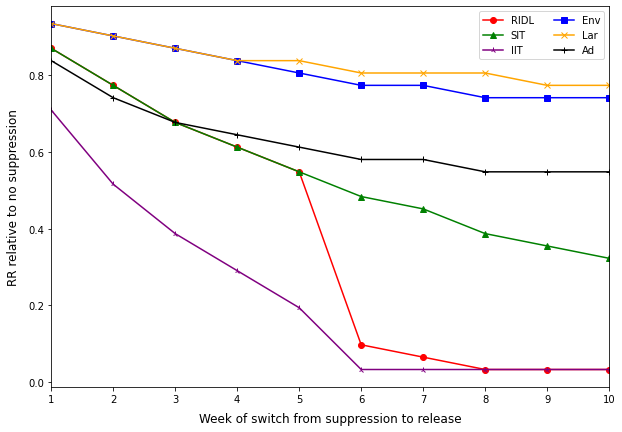

In [11]:
fig, ax2 = plt.subplots(figsize=(10,7))

ax2.plot(t, w1, 'red', marker="o", label="RIDL")
ax2.plot(t, w2, 'green', marker="^", label="SIT")
ax2.plot(t, w3, 'purple', marker="2", label="IIT")
ax2.plot(t, w4, 'blue', marker="s", label="Env")
ax2.plot(t, w5, 'orange', marker="x", label="Lar")
ax2.plot(t, w6, 'black', marker="+", label="Ad")
plt.xticks(np.linspace(1,10,10))
ax2.set_xlim(1,10)
ax2.set_xlabel("Week of switch from suppression to release", fontsize=12, labelpad=8)
ax2.set_ylabel("RR relative to no suppression", fontsize=12, labelpad=8)
ax2.legend(loc='upper right', ncol=2)
#ax2.set_title("Minimum RR required to reach 95% fixation\n of Wolbachia within 6 months")

#plt.savefig('Fig5B.jpeg', dpi=600, bbox_inches='tight',)